# Starting point
In my previous notebooks I have experimented with extending the MNIST data set by shifting the digits, dimensionality reduction using PCA and classification using both KNN and some ensemble methods.

My best result on the Kaggle test set has so far been 98.34% accuracy using with this approach:
* The full test set of 42 000 images was extended to 210 000 images by shifting each image one pixel in each direction
* PCA was performed on the full test set to reduce it to 80% explained variance ratio, or 47 components
* A 3-Nearest-Neighbours model was trained on the full training set of 210 000 images

In this notebook I will try to tackle the MNIST data set using a Deep Neural Network.
I have little experience with deep learning, so I will start of just using the basic concepts:
* Fully connected layers
* Simpel activation functions (logit or ReLU)
* Limited number of hidden layers, most likely just 2
* Backpropagation using Stochastic Gradient Descent

I will be implementing my model using Keras, with Tensorflow as backend.

# The Data
All pixels take values in the range [0, 255], I will normalise them to [0, 1].
I might opt to extend the data set by shifting the digits like I did in previous notebooks, but first I want to get a feeling for what the training time is like on the standard training set.

Also, like in `4. Handwritten Digits - Ensemble Learning` I will opt to set aside a validation set of 8 000 images.

In [2]:
import pandas as pd
import numpy as np
import keras

Using TensorFlow backend.


## Training set

In [3]:
data_df = pd.read_csv('train.csv')
digits = data_df.iloc[:, 1:].values
labels = data_df['label'].values

## Test set

In [4]:
test_df = pd.read_csv('test.csv')
digits_test = test_df.values

## Modify the data

One-hot encode the labels.

In [5]:
from sklearn.preprocessing import OneHotEncoder

In [6]:
labels_one_hot = OneHotEncoder().fit_transform(labels.reshape(-1,1))

Scale the pixels.

In [7]:
digits_scaled = digits / 255
digits_test_scaled = digits_test / 255

## Validation set

In [8]:
from sklearn.model_selection import train_test_split
X, X_val, y, y_val = train_test_split(digits_scaled, labels_one_hot, test_size = 8000, stratify = labels_one_hot.toarray(), random_state = 0)

# Deep Neural Network
In the book `Hands-On Machine Learning with Scikit-Learn & TensorFlow` Aurélien Géron suggests a simple Deep Neural Network architecture for the MNIST set:
* Hidden Layer 1
    * 300 Nodes, ReLU activation
* Hidden Layer 2
    * 100 Nodes, ReLU activation
I will try to copy his approach.

## Setting up my first model

I will use a simple sequential model. 

In [9]:
from keras.models import Sequential

model = Sequential()

I will only be using completely connected layers.

In [10]:
from keras.layers import Dense

Two hidden layers with the ReLU activation function.

In [50]:
model.add(Dense(units=300, activation='relu', input_dim=28*28))
model.add(Dense(units=100, activation='relu'))

A softmax output layer.

In [51]:
model.add(Dense(units=10, activation='softmax'))

Compile the model, use cross entropy as loss function and stochastic gradient descent for backpropagation. Accuracy should be used to measure performance.

In [52]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

Lets just do a super small training run to start of.

In [77]:
model.fit(X, y, epochs=100, batch_size=64, verbose=0)

In [85]:
loss_and_metrics_train = model.evaluate(X, y, batch_size=64)
loss_and_metrics_val = model.evaluate(X_val, y_val, batch_size=64)

8000/8000 [==============================] - 1s 68us/step


In [86]:
print("{} accuracy on validation set".format(loss_and_metrics_train[1]))
print("{} accuracy on validation set".format(loss_and_metrics_val[1]))

0.9996764705882353 accuracy on validation set
0.974125 accuracy on validation set


After slightly more than 500 epochs I see 97% accuracy on the validation set, and close to 100% accuracy on the training set. 
100% accuracy on the traing data means that my model has converged, and will not be making any new progress. Unfortunately the lower accuracy on the validation set means that I have overfitted the training data.


Lets play around with some other approaches to see if I can avoid overfitting.

# Model Number Two
Lets set the number of nodes to 150 for both layers and see if there is a noticable difference.

In [107]:
model2 = Sequential()

model2.add(Dense(units=150, activation='relu', input_dim=28*28))
model2.add(Dense(units=150, activation='relu'))

model2.add(Dense(units=10, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

This time, lets keep track of how validation accuracy develops during training.

In [108]:
validation_accuracies = []
train_accuracies = []
epoch_batches = 10
batches = 50

In [ ]:
for i in range(batches):
    model2.fit(X, y, epochs=epoch_batches, batch_size=1024, verbose=0)
    train_acc = model2.evaluate(X, y, batch_size=1024, verbose=0)[1]
    val_acc = model2.evaluate(X_val, y_val, batch_size=1024, verbose=0)[1]
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)
    print("{} epochs passed, train accuracy {}, validation accuracy {}".format((i+1)*epoch_batches, round(train_acc,4 ), round(val_acc, 4)))
    

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [124]:
df = pd.DataFrame(index=np.arange(epoch_batches, epoch_batches * batches+1, epoch_batches), 
                  data=np.asarray([train_accuracies, validation_accuracies]).T, 
                  columns = ['Training Accuracy', 'Validation Accuracy'])

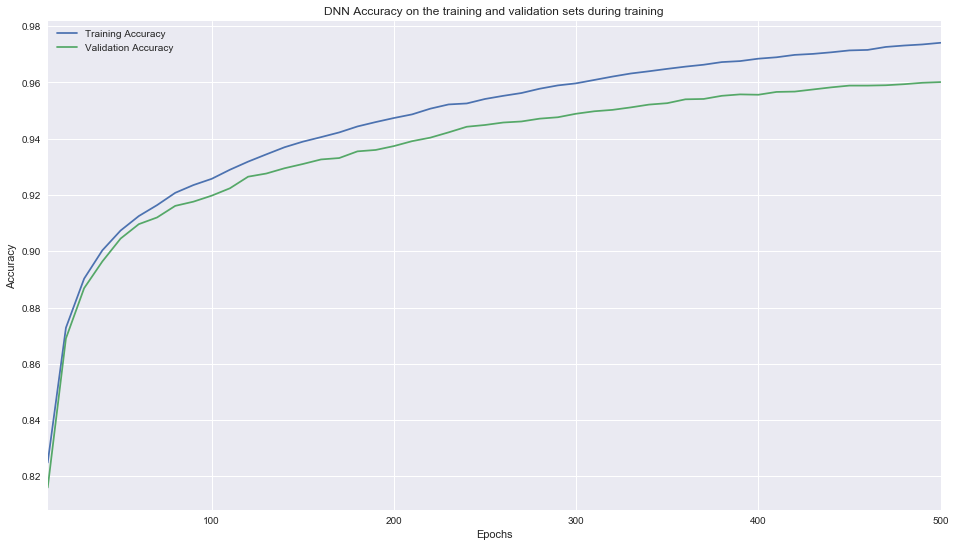

In [125]:
f, ax = plt.subplots(figsize=(16, 9))

df.plot(ax=ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel('Epochs')
ax.set_title('DNN Accuracy on the training and validation sets during training')


This model did not have time to converge in 500 epochs, but it already shows signs of overfitting the data.
Validation Accuracy is 1.4 percentage units behind the training set, it seems unlikely that this difference will decrease with more training. 
So, even if both accuracies keep going up I will probably not get a validation accuracy better than 98.6%, probably lower.
I should try to apply some regularization.

# Model Number Three
Lets keep the same model as last time, but add dropout layers after both hidden layers.
The concept of dropout layers is super simple.
For each update of the network we ignore any node with some probability, I will use 50%.
The node is then brought back for the next run, and all nodes are used when predicting results with the final model.

Why using dropout layers is a good idea is not something I have read enough about, but Aurélien Géron gives some nice intuition on why it is helpful. He points out that due to the randomness of what nodes are dropped out, we will be seing a unique netowrk at each stage of training.
These networks will share weights, but will still represent vastly different networks. 
This could lead to a model with lower variance, similar to how an ensemble of many models can reduce variance.

In [11]:
from keras.layers import Dropout

In [127]:
model3 = Sequential()

model3.add(Dense(units=150, activation='relu', input_dim=28*28))
model3.add(Dropout(rate=.5, seed = 0))
model3.add(Dense(units=150, activation='relu'))
# Lets use a different randomseed for the second dropout layer so I dont risk having symetric droputs
model3.add(Dropout(rate=.5, seed = 1))

model3.add(Dense(units=10, activation='softmax'))

model3.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

This time, lets keep track of how validation accuracy develops during training.

In [128]:
validation_accuracies = []
train_accuracies = []
epoch_batches = 10
batches = 50

In [ ]:
for i in range(batches):
    model3.fit(X, y, epochs=epoch_batches, batch_size=1024, verbose=0)
    train_acc = model3.evaluate(X, y, batch_size=1024, verbose=0)[1]
    val_acc = model3.evaluate(X_val, y_val, batch_size=1024, verbose=0)[1]
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)
    print("{} epochs passed, train accuracy {}, validation accuracy {}".format((i+1)*epoch_batches, round(train_acc,4 ), round(val_acc, 4)))
    

In [130]:
df = pd.DataFrame(index=np.arange(epoch_batches, epoch_batches * batches+1, epoch_batches), 
                  data=np.asarray([train_accuracies, validation_accuracies]).T, 
                  columns = ['Training Accuracy', 'Validation Accuracy'])

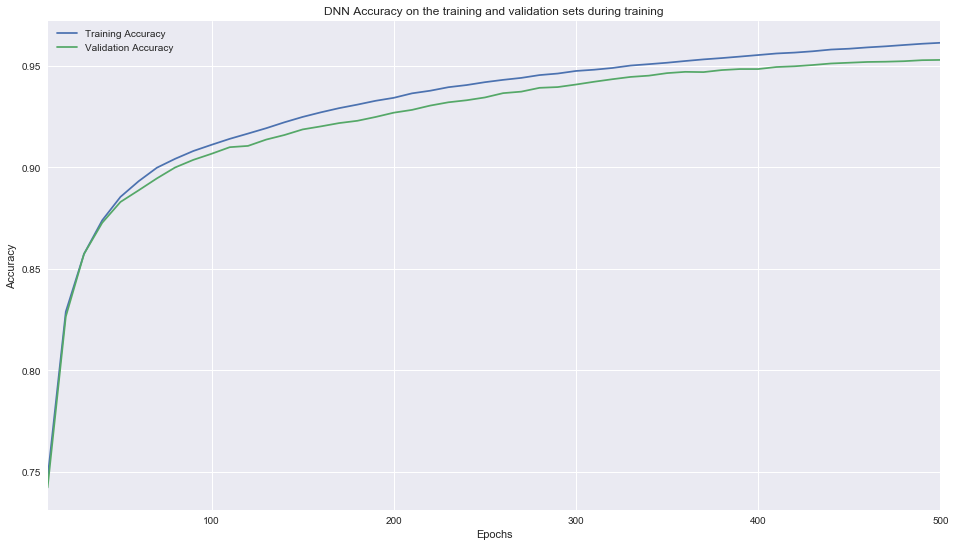

In [131]:
f, ax = plt.subplots(figsize=(16, 9))

df.plot(ax=ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel('Epochs')
ax.set_title('DNN Accuracy on the training and validation sets during training')


Two things have changed:
* This model is converging slower, it only reached an accuracy of 96% on the training set after 500 epochs
* This model is not overfitting as much as the previous model, though training accuracy is still larger than validation accuracy

Lets give it another 500 epochs and see where it gets!

In [ ]:
for i in range(batches):
    model3.fit(X, y, epochs=epoch_batches, batch_size=1024, verbose=0)
    train_acc = model3.evaluate(X, y, batch_size=1024, verbose=0)[1]
    val_acc = model3.evaluate(X_val, y_val, batch_size=1024, verbose=0)[1]
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)
    print("{} epochs passed, train accuracy {}, validation accuracy {}".format(500 + (i+1)*epoch_batches, round(train_acc,4 ), round(val_acc, 4)))
    

In [133]:
df = pd.DataFrame(index=np.arange(epoch_batches, 500 + epoch_batches * batches+1, epoch_batches), 
                  data=np.asarray([train_accuracies, validation_accuracies]).T, 
                  columns = ['Training Accuracy', 'Validation Accuracy'])

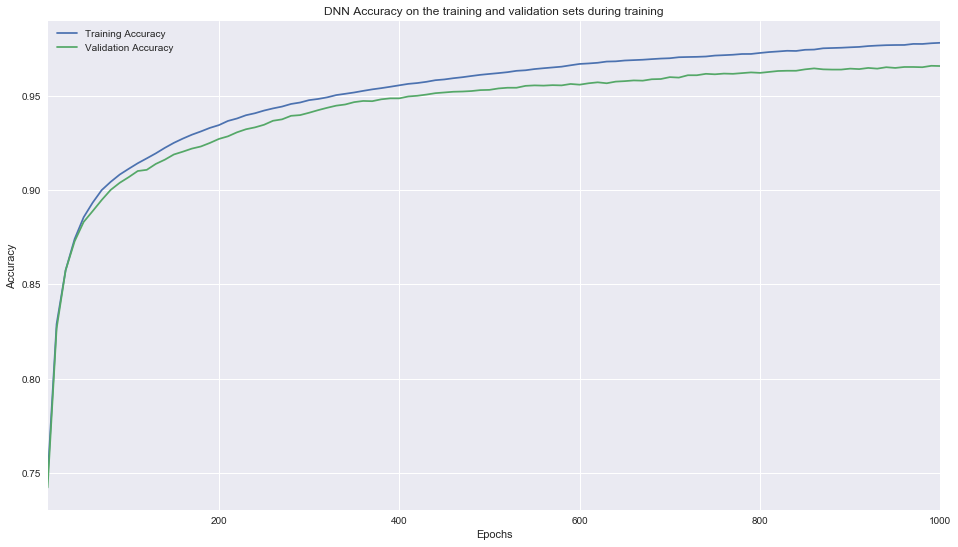

In [134]:
f, ax = plt.subplots(figsize=(16, 9))

df.plot(ax=ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel('Epochs')
ax.set_title('DNN Accuracy on the training and validation sets during training')


I have surpassed the training accuracy of model number two, and validation accuracy is now only lagging behind with 1.2 percentage units.

I would like to keep training the model, but only until the point where validation accuracy stops improving.

Lets save the current model, and then keep on training. I will save the model with the best validation accuracy.

In [136]:
model3.save('keras_models/model3.h5')

In [146]:
from keras.models import load_model
model3_new = load_model('keras_models/model3.h5')

In [12]:
from keras.callbacks import ModelCheckpoint

In [148]:
best_model_path = 'keras_models/best.h5'

In [149]:
checkpoint = ModelCheckpoint(best_model_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [150]:
model3_new.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'],
              validation_data = (X_val, y_val)  
                  )

In [155]:
for i in range(2*batches):
    model3.fit(X, y, epochs=epoch_batches, batch_size=1024, verbose=0, callbacks=callbacks_list, validation_data = (X_val, y_val))
    train_acc = model3.evaluate(X, y, batch_size=1024, verbose=0)[1]
    val_acc = model3.evaluate(X_val, y_val, batch_size=1024, verbose=0)[1]
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)
    #print("{} epochs passed, train accuracy {}, validation accuracy {}".format(500 + (i+1)*epoch_batches, round(train_acc,4 ), round(val_acc, 4)))
    

In [162]:
print("Best result:")
print("{} validation accuracy on the validation set after {} epochs".format(np.max(validation_accuracies), np.argmax(validation_accuracies) * epoch_batches+ 10))

Best result:
0.9707500004768371 validation accuracy on the validation set after 1980 epochs


In [156]:
df = pd.DataFrame(index=np.arange(epoch_batches, 1000 + 2* epoch_batches * batches+1, epoch_batches), 
                  data=np.asarray([train_accuracies, validation_accuracies]).T, 
                  columns = ['Training Accuracy', 'Validation Accuracy'])

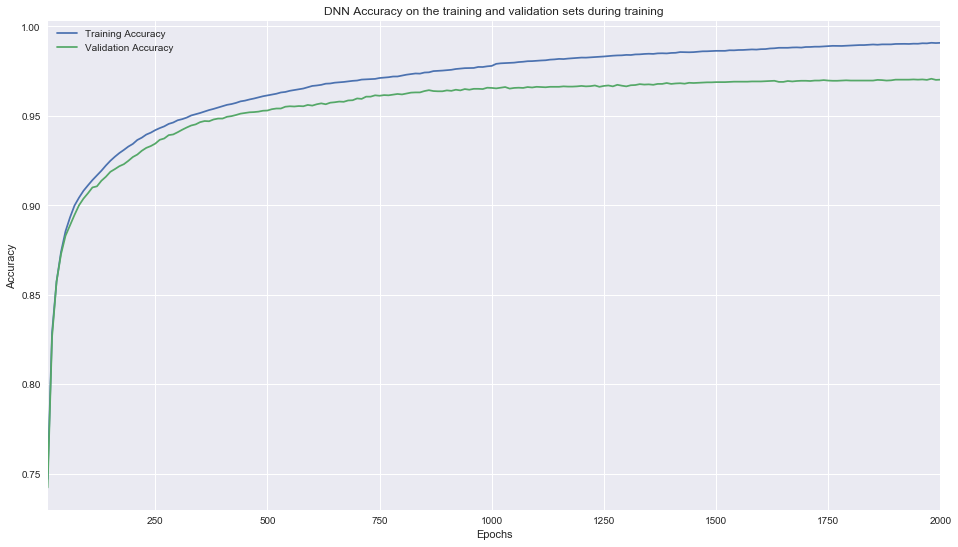

In [157]:
f, ax = plt.subplots(figsize=(16, 9))

df.plot(ax=ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel('Epochs')
ax.set_title('DNN Accuracy on the training and validation sets during training')


Okay, so the best result on the validation set was just 20 epochs befor stopping.
It will probably improve some more as the model gets closer to converging, but I don't like that validation accuracy is lagging so far behind training accuracy.

Lets help future models to converge faster by performing PCA on the input.

# PCA
Based on previous notebooks I know I am able to reduce the number of features substantially while keeping a high variance among the featutres. 
I will try both 80% and 90% variance ratio.

In [13]:
from sklearn.decomposition import PCA

In [14]:
pca_80 = PCA(n_components=.8)
pca_80.fit(X)

pca_90 = PCA(n_components=.9)
pca_90.fit(X)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [15]:
pca_80.n_components_

43

In [16]:
pca_90.n_components_

87

In [17]:
X_80, X_val_80 = pca_80.transform(X), pca_80.transform(X_val)

# Model Number Four
Lets go for an even simpler model, two hidden layers with 64 nodes each. 
I will still use dropout.

For starters I will use the data set reduced to 80% variance.

In [169]:
model4 = Sequential()

model4.add(Dense(units=64, activation='relu', input_dim=pca_80.n_components_))
model4.add(Dropout(rate=.5, seed = 0))
model4.add(Dense(units=64, activation='relu'))
# Lets use a different randomseed for the second dropout layer so I dont risk having symetric droputs
model4.add(Dropout(rate=.5, seed = 1))

model4.add(Dense(units=10, activation='softmax'))

model4.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [173]:
validation_accuracies4 = []
train_accuracies4 = []
epoch_batches = 10
batches = 200

In [ ]:
for i in range(batches):
    model4.fit(X_80, y, epochs=epoch_batches, batch_size=1024, verbose=0)
    train_acc = model4.evaluate(X_80, y, batch_size=1024, verbose=0)[1]
    val_acc = model4.evaluate(X_val_80, y_val, batch_size=1024, verbose=0)[1]
    train_accuracies4.append(train_acc)
    validation_accuracies4.append(val_acc)
    print("{} epochs passed, train accuracy {}, validation accuracy {}".format((i+1)*epoch_batches, round(train_acc,4 ), round(val_acc, 4)))
    

In [182]:
df = pd.DataFrame(index=np.arange(epoch_batches, len(train_accuracies4) * epoch_batches + 1, epoch_batches), 
                  data=np.asarray([train_accuracies4, validation_accuracies4]).T, 
                  columns = ['Training Accuracy', 'Validation Accuracy'])

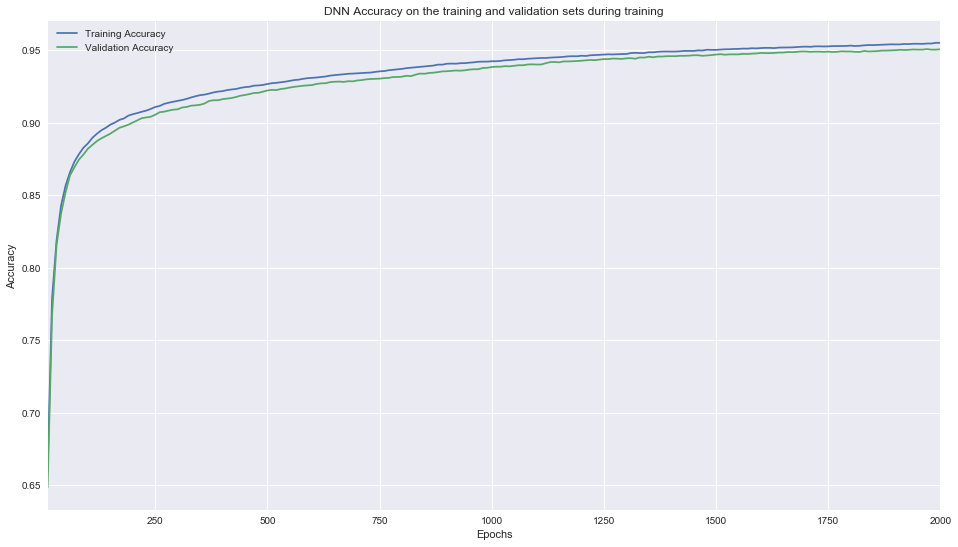

In [183]:
f, ax = plt.subplots(figsize=(16, 9))

df.plot(ax=ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel('Epochs')
ax.set_title('DNN Accuracy on the training and validation sets during training')


In [184]:
print("Best result:")
print("{} accuracy on the validation set after {} epochs".format(np.max(validation_accuracies4), np.argmax(validation_accuracies4) * epoch_batches+ 10))

Best result:
0.9506250019073487 accuracy on the validation set after 1970 epochs


2000 epochs passed much faster this time, but did not lead to very good accuracy, only 95%.
The network is converging much more slowly, and it looks like it might even end up underfitting the data.
I suspect a dropout rate of 50% might be to much for this network which is much smaller.

# Model number five
Lets keep the same architecutre as model four, but with a dropout rate of 10% instead.

In [189]:
model5 = Sequential()

model5.add(Dense(units=64, activation='relu', input_dim=pca_80.n_components_))
model5.add(Dropout(rate=.1, seed = 0))
model5.add(Dense(units=64, activation='relu'))
# Lets use a different randomseed for the second dropout layer so I dont risk having symetric droputs
model5.add(Dropout(rate=.1, seed = 1))

model5.add(Dense(units=10, activation='softmax'))

model5.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [190]:
validation_accuracies5 = []
train_accuracies5 = []
epoch_batches = 10
batches = 200

In [ ]:
for i in range(batches):
    model5.fit(X_80, y, epochs=epoch_batches, batch_size=1024, verbose=0)
    train_acc = model5.evaluate(X_80, y, batch_size=1024, verbose=0)[1]
    val_acc = model5.evaluate(X_val_80, y_val, batch_size=1024, verbose=0)[1]
    train_accuracies5.append(train_acc)
    validation_accuracies5.append(val_acc)
    print("{} epochs passed, train accuracy {}, validation accuracy {}".format((i+1)*epoch_batches, round(train_acc,4 ), round(val_acc, 4)))
    

In [192]:
df = pd.DataFrame(index=np.arange(epoch_batches, len(train_accuracies5) * epoch_batches + 1, epoch_batches), 
                  data=np.asarray([train_accuracies5, validation_accuracies5]).T, 
                  columns = ['Training Accuracy', 'Validation Accuracy'])

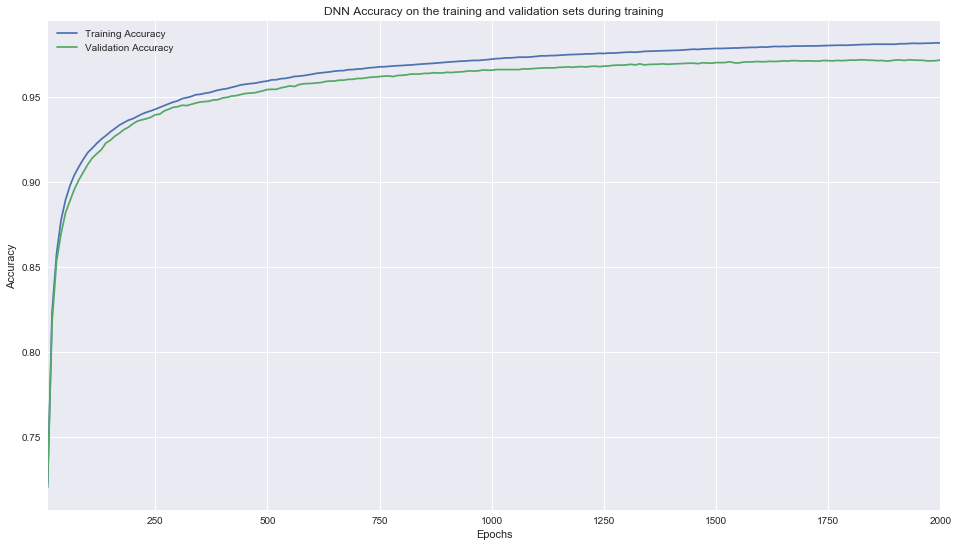

In [193]:
f, ax = plt.subplots(figsize=(16, 9))

df.plot(ax=ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel('Epochs')
ax.set_title('DNN Accuracy on the training and validation sets during training')


In [194]:
print("Best result:")
print("{} accuracy on the validation set after {} epochs".format(np.max(validation_accuracies5), np.argmax(validation_accuracies5) * epoch_batches+ 10))

Best result:
0.9720000023841858 accuracy on the validation set after 1930 epochs


The model reached an acceptable accuracy mch faster compared to model four, but shows serious signs of overfitting the training set: The validation accuracy was not increased at all in the last 70 epochs.

I will increase dropout rate again, and also try an activation function that might converge faster, the Exponential Linear Unit (ELU).

# Model number six

In [196]:
model6 = Sequential()

model6.add(Dense(units=64, activation='elu', input_dim=pca_80.n_components_))
model6.add(Dropout(rate=.25, seed = 0))
model6.add(Dense(units=64, activation='elu'))
# Lets use a different randomseed for the second dropout layer so I dont risk having symetric droputs
model6.add(Dropout(rate=.1, seed = 1))

model6.add(Dense(units=10, activation='softmax'))

model6.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [197]:
validation_accuracies6 = []
train_accuracies6 = []
epoch_batches = 10
batches = 200

In [ ]:
for i in range(batches):
    model6.fit(X_80, y, epochs=epoch_batches, batch_size=1024, verbose=0)
    train_acc = model6.evaluate(X_80, y, batch_size=1024, verbose=0)[1]
    val_acc = model6.evaluate(X_val_80, y_val, batch_size=1024, verbose=0)[1]
    train_accuracies6.append(train_acc)
    validation_accuracies6.append(val_acc)
    print("{} epochs passed, train accuracy {}, validation accuracy {}".format((i+1)*epoch_batches, round(train_acc,4 ), round(val_acc, 4)))
    

In [199]:
df = pd.DataFrame(index=np.arange(epoch_batches, len(train_accuracies6) * epoch_batches + 1, epoch_batches), 
                  data=np.asarray([train_accuracies6, validation_accuracies6]).T, 
                  columns = ['Training Accuracy', 'Validation Accuracy'])

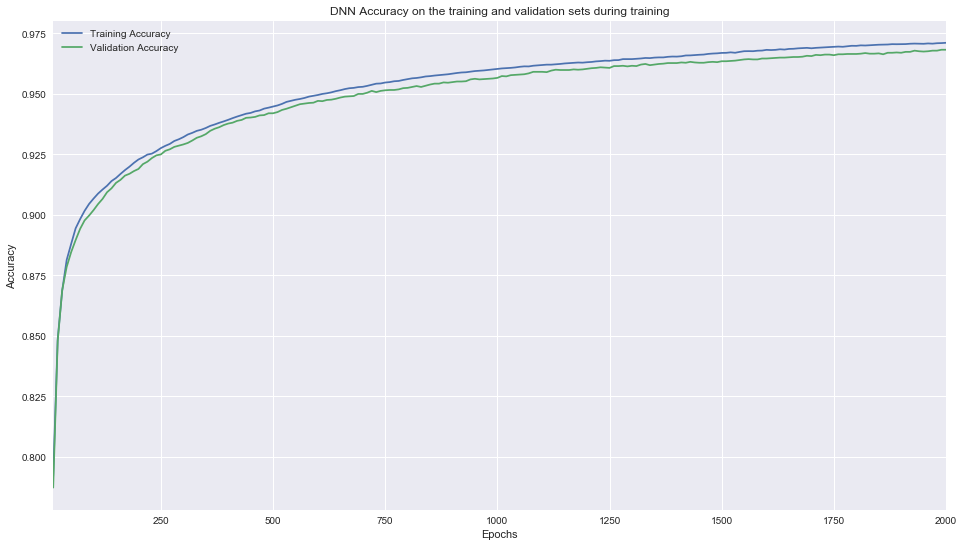

In [200]:
f, ax = plt.subplots(figsize=(16, 9))

df.plot(ax=ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel('Epochs')
ax.set_title('DNN Accuracy on the training and validation sets during training')


In [202]:
print("Best result:")
print("{} accuracy on the validation set after {} epochs".format(np.max(validation_accuracies6), np.argmax(validation_accuracies6) * epoch_batches+ 10))

Best result:
0.9682499990463257 accuracy on the validation set after 1990 epochs


Validation and training accuracy are still slowly increasing after 2000 epochs, with little signs of overfitting.
I could perhaps get good results by letting the model train some more, but I would rather see i I can find a model that converges a little bit faster.

One thing I can try is to change optimizer from standard gradient descent optimization to using adaptive moment estimation, also knows as ADAM.

# Model number 6.5
First, I will try to keep on training model 6 but with ADAM optimization.

In [205]:
model6.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
for i in range(batches):
    model6.fit(X_80, y, epochs=epoch_batches, batch_size=1024, verbose=0)
    train_acc = model6.evaluate(X_80, y, batch_size=1024, verbose=0)[1]
    val_acc = model6.evaluate(X_val_80, y_val, batch_size=1024, verbose=0)[1]
    train_accuracies6.append(train_acc)
    validation_accuracies6.append(val_acc)
    print("{} epochs passed, train accuracy {}, validation accuracy {}".format(2000 + (i+1)*epoch_batches, round(train_acc,4 ), round(val_acc, 4)))
    

In [207]:
df = pd.DataFrame(index=np.arange(epoch_batches, len(train_accuracies6) * epoch_batches + 1, epoch_batches), 
                  data=np.asarray([train_accuracies6, validation_accuracies6]).T, 
                  columns = ['Training Accuracy', 'Validation Accuracy'])

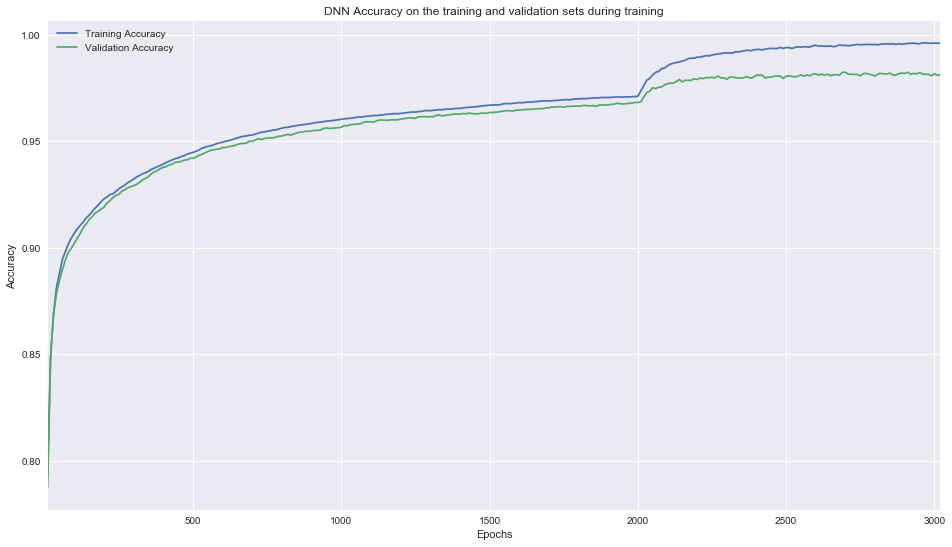

In [208]:
f, ax = plt.subplots(figsize=(16, 9))

df.plot(ax=ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel('Epochs')
ax.set_title('DNN Accuracy on the training and validation sets during training')


In [209]:
print("Best result:")
print("{} accuracy on the validation set after {} epochs".format(np.max(validation_accuracies6), np.argmax(validation_accuracies6) * epoch_batches+ 10))

Best result:
0.982375 accuracy on the validation set after 2690 epochs


We see a huge bump in training speed after switching to ADAM after 2000 epochs, however the effect was much more visible in the training accuracy compared to the validation accuracy. Once again the model runs of overfitting the data.

Lets atempt a new regularization technique, batch normalization.

# Model number seven
Lets use the same model as last time, but with batch normalization befor each hidden layer. 
Batch normalization centers the input of a layer around 0 and normalises the inputs. 
It does so on a per batch basis during training.

Batch normalization has many up-sides, one of wich is faster convergense and regularization.

In [18]:
from keras.layers import BatchNormalization

In [21]:
model7 = Sequential()

model7.add(BatchNormalization(input_shape = (pca_80.n_components_,)))
model7.add(Dense(units=64, activation='elu'))
model7.add(Dropout(rate=.25, seed = 0))
model7.add(BatchNormalization())
model7.add(Dense(units=64, activation='elu'))
# Lets use a different randomseed for the second dropout layer so I dont risk having symetric droputs
model7.add(Dropout(rate=.1, seed = 1))

model7.add(Dense(units=10, activation='softmax'))

model7.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
validation_accuracies7 = []
train_accuracies7 = []
epoch_batches = 10
batches = 100

In [ ]:
for i in range(batches):
    model7.fit(X_80, y, epochs=epoch_batches, batch_size=1024, verbose=0)
    train_acc = model7.evaluate(X_80, y, batch_size=1024, verbose=0)[1]
    val_acc = model7.evaluate(X_val_80, y_val, batch_size=1024, verbose=0)[1]
    train_accuracies7.append(train_acc)
    validation_accuracies7.append(val_acc)
    print("{} epochs passed, train accuracy {}, validation accuracy {}".format((i+1)*epoch_batches, round(train_acc,4 ), round(val_acc, 4)))
    

In [24]:
df = pd.DataFrame(index=np.arange(epoch_batches, len(train_accuracies7) * epoch_batches + 1, epoch_batches), 
                  data=np.asarray([train_accuracies7, validation_accuracies7]).T, 
                  columns = ['Training Accuracy', 'Validation Accuracy'])

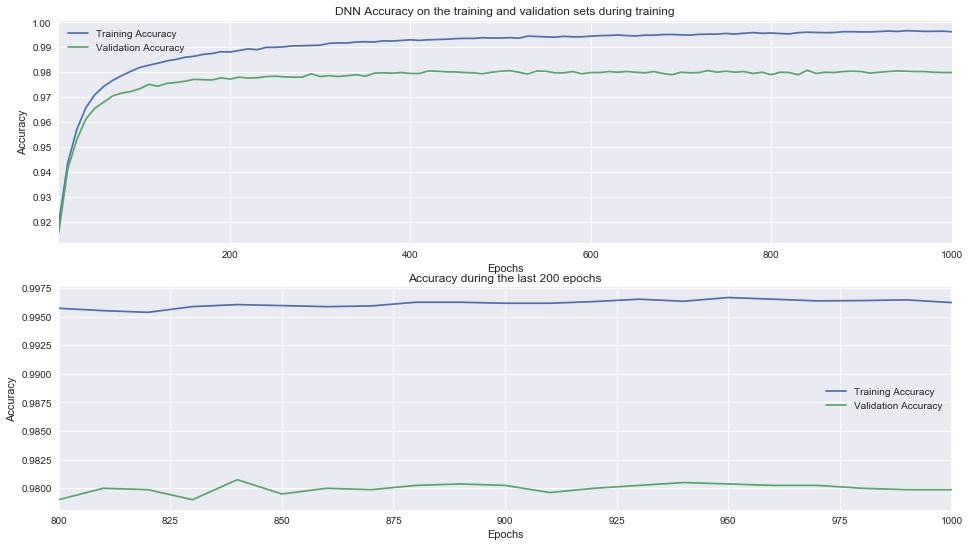

In [27]:
f, ax = plt.subplots(2, 1, figsize=(16, 9))

df.plot(ax=ax[0])
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel('Epochs')
ax[0].set_title('DNN Accuracy on the training and validation sets during training')

df.loc[800:].plot(ax=ax[1])
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel('Epochs')
ax[1].set_title('Accuracy during the last 200 epochs')


In [28]:
print("Best result:")
print("{} accuracy on the validation set after {} epochs".format(np.max(validation_accuracies7), np.argmax(validation_accuracies7) * epoch_batches+ 10))

Best result:
0.9807499995231629 accuracy on the validation set after 840 epochs


I get some good results pretty quickly, 98% validation accuracy after 400 epochs. However, after that point the training clearly stagnates. The model looks like ithas almost converged, but does not generalise that well to the validation set.

So, now we have a model that quickly converges to a good traing set accuracy, but overfits.
Model four that used 50% dropout looked primising in terms of generalizing its training set results to the validation set, but it converged really slowly.
Lets try the same dropout rate again, but together with ADAM and batch normalization.

# Model number eight

In [29]:
model8 = Sequential()

model8.add(BatchNormalization(input_shape = (pca_80.n_components_,)))
model8.add(Dense(units=64, activation='elu'))
model8.add(Dropout(rate=.5, seed = 0))
model8.add(BatchNormalization())
model8.add(Dense(units=64, activation='elu'))
# Lets use a different randomseed for the second dropout layer so I dont risk having symetric droputs
model8.add(Dropout(rate=.5, seed = 1))

model8.add(Dense(units=10, activation='softmax'))

model8.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
validation_accuracies8 = []
train_accuracies8 = []
epoch_batches = 10
batches = 100

In [31]:
for i in range(batches):
    model8.fit(X_80, y, epochs=epoch_batches, batch_size=1024, verbose=0)
    train_acc = model8.evaluate(X_80, y, batch_size=1024, verbose=0)[1]
    val_acc = model8.evaluate(X_val_80, y_val, batch_size=1024, verbose=0)[1]
    train_accuracies8.append(train_acc)
    validation_accuracies8.append(val_acc)
    print("{} epochs passed, train accuracy {}, validation accuracy {}".format((i+1)*epoch_batches, round(train_acc,4 ), round(val_acc, 4)))
    

10 epochs passed, train accuracy 0.9017, validation accuracy 0.8961
20 epochs passed, train accuracy 0.9123, validation accuracy 0.908
30 epochs passed, train accuracy 0.9186, validation accuracy 0.916
40 epochs passed, train accuracy 0.9258, validation accuracy 0.9227
50 epochs passed, train accuracy 0.9316, validation accuracy 0.9296
60 epochs passed, train accuracy 0.9364, validation accuracy 0.9346
70 epochs passed, train accuracy 0.9407, validation accuracy 0.9376
80 epochs passed, train accuracy 0.9446, validation accuracy 0.941
90 epochs passed, train accuracy 0.9471, validation accuracy 0.9444
100 epochs passed, train accuracy 0.9488, validation accuracy 0.947
110 epochs passed, train accuracy 0.9515, validation accuracy 0.9488
120 epochs passed, train accuracy 0.9526, validation accuracy 0.9515
130 epochs passed, train accuracy 0.9539, validation accuracy 0.9523
140 epochs passed, train accuracy 0.9553, validation accuracy 0.9532
150 epochs passed, train accuracy 0.9564, valid

In [32]:
df = pd.DataFrame(index=np.arange(epoch_batches, len(train_accuracies8) * epoch_batches + 1, epoch_batches), 
                  data=np.asarray([train_accuracies8, validation_accuracies8]).T, 
                  columns = ['Training Accuracy', 'Validation Accuracy'])

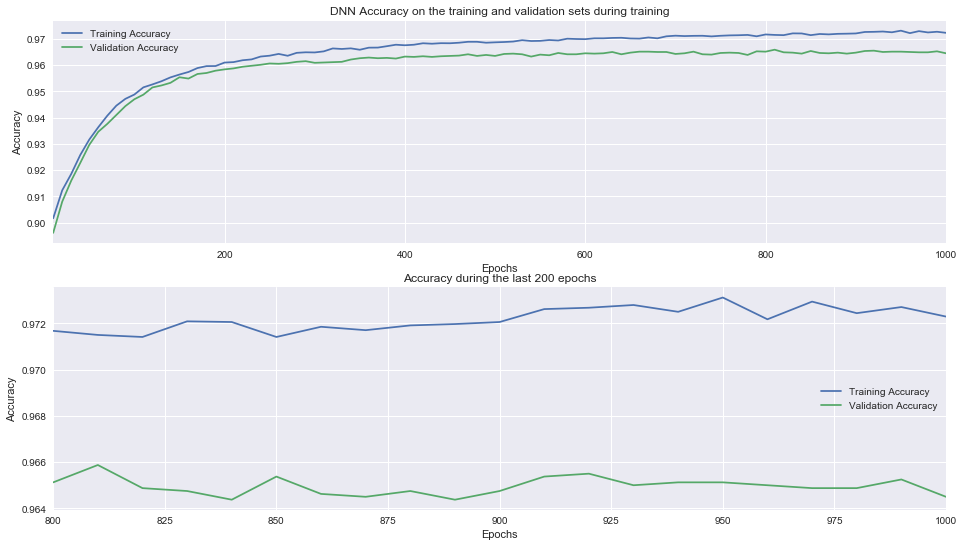

In [33]:
f, ax = plt.subplots(2, 1, figsize=(16, 9))

df.plot(ax=ax[0])
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel('Epochs')
ax[0].set_title('DNN Accuracy on the training and validation sets during training')

df.loc[800:].plot(ax=ax[1])
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel('Epochs')
ax[1].set_title('Accuracy during the last 200 epochs')


In [34]:
print("Best result:")
print("{} accuracy on the validation set after {} epochs".format(np.max(validation_accuracies8), np.argmax(validation_accuracies8) * epoch_batches+ 10))

Best result:
0.965875 accuracy on the validation set after 810 epochs


This model clearly underfits the data instead, perhaps 50% dropout in both layers is to harsh.

# More models
Okay, it has been fun iterating forward and manually updating hyperparameters and layers between each run.
But now I just want to find a good level of regularization by tuning the drop out rates of the drop out layers.

Lets use random search.

In [230]:
from keras.wrappers.scikit_learn import KerasClassifier

In [467]:
def build_model(nodes = [64, 64], dropouts = [0, 0], n_inputs=pca_80.n_components_):
    model = Sequential()

    model.add(BatchNormalization(input_shape = (n_inputs,)))
    model.add(Dense(units=nodes[0], activation='elu'))
    model.add(Dropout(rate=dropouts[0], seed = 0))
    model.add(BatchNormalization())
    model.add(Dense(units=nodes[1], activation='elu'))
    # Lets use a different randomseed for the second dropout layer so I dont risk having symetric droputs
    model.add(Dropout(rate=dropouts[1], seed = 1))

    model.add(Dense(units=10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [313]:
model = KerasClassifier(build_fn = build_model)

In [314]:
from sklearn.model_selection import RandomizedSearchCV

In [315]:
param_dist = {"nodes": [[64, 64], [128, 64], [64, 32]],
              "dropouts": [[.1, 0], [.25, 0], [.25, .1], [.5, 0], [.5, .1], [.1, .25]] }

In [333]:
random_search = RandomizedSearchCV(model, cv=[[range(len(X)), range(len(X_val))]], param_distributions=param_dist, n_iter=5, scoring="accuracy", verbose=2)

In [ ]:
random_search.fit(np.concatenate([X_80, X_val_80]), np.concatenate([[ np.where(r==1)[0][0] for r in y.toarray() ], [ np.where(r==1)[0][0] for r in y_val.toarray() ]]), epochs=1000, batch_size=1024, verbose=0)

ABORT, ABORT

I have to little patience to spend by evening waiting for these 5 models to converge without getting to interact my self. 
Lets try some of the more extreme values just to see that I am not iterating across solutions close to a "local minimum".

In [397]:
model = build_model([128, 64], [.5, .1])

In [398]:
epoch_batches = 10
batches = 100

In [415]:
def train(model, X, X_val, y, y_val, epoch_batches, batches, batch_size, callbacks = None,validation_data=None):
    validation_accuracies = []
    train_accuracies = []
    for i in range(batches):
        model.fit(X, y, epochs=epoch_batches, batch_size=batch_size, verbose=0, callbacks=callbacks, validation_data=validation_data)
        train_acc = model.evaluate(X, y, batch_size=batch_size, verbose=0)[1]
        val_acc = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)[1]
        train_accuracies.append(train_acc)
        validation_accuracies.append(val_acc)
        print("{} epochs passed, train accuracy {}, validation accuracy {}".format((i+1)*epoch_batches, round(train_acc,4 ), round(val_acc, 4)))
    return train_accuracies, validation_accuracies

In [ ]:
%time train_accuracies, validation_accuracies = train(model, X_80, X_val_80, y, y_val, epoch_batches, batches, 512)

Wall time: 30min 14s

In [409]:
def visualise_training(training_accuracies, validation_accuracies, epoch_batches):
    df = pd.DataFrame(index=np.arange(epoch_batches, len(train_accuracies) * epoch_batches + 1, epoch_batches), 
                  data=np.asarray([train_accuracies, validation_accuracies]).T, 
                  columns = ['Training Accuracy', 'Validation Accuracy'])
    f, ax = plt.subplots(2, 1, figsize=(16, 9))

    df.plot(ax=ax[0])
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel('Epochs')
    ax[0].set_title('DNN Accuracy on the training and validation sets during training')

    df.loc[800:].plot(ax=ax[1])
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xlabel('Epochs')
    ax[1].set_title('Accuracy during the last 200 epochs')
    print("Best result:")
    print("{} accuracy on the validation set after {} epochs".format(np.max(validation_accuracies), np.argmax(validation_accuracies) * epoch_batches+ 10))

Best result:
0.983125 accuracy on the validation set after 560 epochs


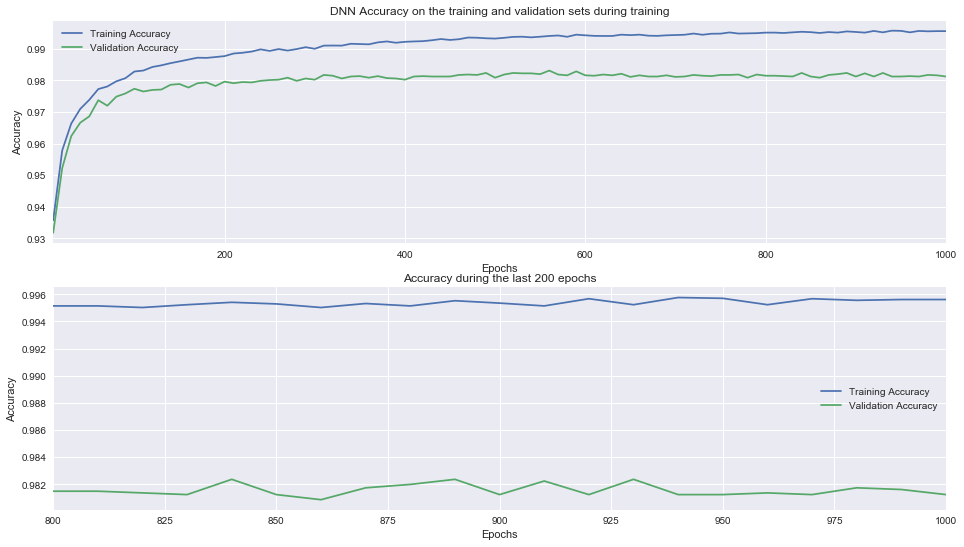

In [410]:
visualise_training(train_accuracies, validation_accuracies, epoch_batches)

98.3% accuracy after 560 epochs, but with significant signs of overfitting. 
Lets use a simpler model again.

In [413]:
from keras.callbacks import EarlyStopping

In [421]:
best_model_path

'keras_models/best.h5'

In [422]:
checkpoint = ModelCheckpoint("keras_models/modelB.h5", monitor='val_acc', verbose=0, save_best_only=True, mode='auto')
callbacks = [checkpoint, EarlyStopping(monitor='val_acc', min_delta=0, patience=50, verbose=0, mode='auto')]

In [417]:
modelB = build_model([64, 64], [.25, .1])

In [ ]:
#%time train_(modelB, X_80, X_val_80, y, y_val, epochs, 512, callbacks, validation_data=[X_val_80, y_val])
%time modelB.fit(X_80, y, epochs=600, batch_size=512, verbose=2, callbacks=callbacks, validation_data=[X_val_80, y_val])

In [427]:
modelB = load_model("keras_models/modelB.h5")

modelB.evaluate(X_val_80, y_val)

8000/8000 [==============================] - 2s 311us/step


[0.064700113778468224, 0.98275000000000001]

98.2 % validation accuracy. Unfortunately I did not save the accuracy progress for this model, as the Early Stopping callback is not compatible with my method of evaluating progress every 10th epoch. 
Lacking this information feels kind of limiting, I will have to look in to what possibilities I have in the future.
I#m sure there is a logging callbakc or something similar.

Anyway, I would like to try my luck with the Kagge test data as well. This model did not reach the best validation accuracy yet, and also I have not evaluated if it seems to overfit the data. 
But yeah, lets try the test set anyway. 

In [434]:
X_test = pca_80.transform(digits_test_scaled)

In [435]:
predictions = modelB.predict_classes(X_test)

In [436]:
submission_df = pd.DataFrame(list(zip(np.arange(1, 28001), predictions)), columns = ['ImageID', 'Label'])
submission_df.set_index('ImageID').to_csv('Submissions/submission9.csv')

97.87% accuracy, pretty good but does not beat KNN.

# Final Model
So I built some intuition on what hyperparameters might be usefull for the MNIST data set. 
For the moment I am growing a little bit tired of slowly iterating forward, especially considering the considerable training times compared to simpler ML models. (~30-60 min per model).

So, lets shoot for the moon and make another attempt at a model to use on the test set.

First of all I will once again extend the training set by shifiting digits one pixel up, down, left and right. 
I will also keep 90% of the input variance instead of 80%, my rationale is that a Nerual Network, unlike a KNN-classifier, has the ability to find out what features are actually usefull, so reducing the number of dimensions should only have negative effect on the models accuracy. However, I still feel that training on all 784 features is unecessary when 90% of the variance can be kept with less than 100 features.

To accomodate for the increased number of features I will use a first hidden layer with 128 features, and a second layer with 64 features. I will keep on using ELU and Batch Normalisation, and use a dropuout rate of 50% for the first layer and 10% for the second layer.

In [437]:
class DigitShifter(BaseEstimator, TransformerMixin):
    def __init__(self, directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]):
        self.directions = directions
    def fit(self, X, y = None):
        return self
    
    # Shifts X in the directions specified by self.directions
    # If y is provided an extended version of y is returned, matching the shifted X
    # If y is not provided None is returned in the second position.
    # Example: X_shifted, _ = transform(X)
    def transform(self, X, y= np.array([])):
        X_shifts = [np.apply_along_axis(lambda x: self.shift_digit(x, direction[0], direction[1]), 1, X) for direction in self.directions]
        y_extended = [y for i in range(len(self.directions) + 1)]
        return np.concatenate([X] + X_shifts), np.concatenate(y_extended) if  y.size != 0 else None
    def shift_digit(self, digit, delta_x=0, delta_y=0):
        digit = digit.reshape(28, 28)
        return shift(digit, (delta_x, delta_y)).flatten()

In [454]:
digits_train, digits_val, labels_train, labels_val = train_test_split(digits, labels, test_size = 8000, stratify = labels, random_state = 0)

In [455]:
digits_extended, labels_extended = DigitShifter().transform(digits_train, labels_train)

In [456]:
# This time I am not doing PCA on the scaled inputs, as that is not necessary
pca90 = PCA(.9)
pca90.fit(digits_extended)

X = pca90.transform(digits_extended)
X_val = pca90.transform(digits_val)

y = OneHotEncoder().fit_transform(labels_extended.reshape(-1,1))
y_val = OneHotEncoder().fit_transform(labels_val.reshape(-1,1))

In [457]:
X.shape

(170000, 91)

In [458]:
y.shape

(170000, 10)

In [459]:
X_val.shape

(8000, 91)

In [460]:
y_val.shape

(8000, 10)

In [468]:
modelC = build_model([128, 64], [.5, .1], pca90.n_components_)

In [469]:
checkpoint = ModelCheckpoint("keras_models/modelC.h5", monitor='val_acc', verbose=0, save_best_only=True, mode='auto')
callbacks = [checkpoint, EarlyStopping(monitor='val_acc', min_delta=0, patience=50, verbose=0, mode='auto')]

In [ ]:
#%time train_(modelB, X_80, X_val_80, y, y_val, epochs, 512, callbacks, validation_data=[X_val_80, y_val])
%time modelC.fit(X, y, epochs=1000, batch_size=256, verbose=2, callbacks=callbacks, validation_data=[X_val, y_val])

(Training accuracy appearing as lower than validation accuracy during training is due to dropout during training.
Keras evaluates training accuracy using the model with dropped nodes, but the whole network to evaluate against the validation set.)

In [471]:
model = load_model("keras_models/modelC.h5")

model.evaluate(X_val, y_val)

8000/8000 [==============================] - 3s 367us/step


[0.051821497409837318, 0.985375]

98.5% validation accuracy, my best result yet! 

In [472]:
X_test = pca90.transform(digits_test)

In [473]:
predictions = model.predict_classes(X_test)

In [474]:
submission_df = pd.DataFrame(list(zip(np.arange(1, 28001), predictions)), columns = ['ImageID', 'Label'])
submission_df.set_index('ImageID').to_csv('Submissions/submission10.csv')

98.48% accuracy on Kaggle, my best so far! Though it is a little bit dissapointing that a deep nerual netowrk is barely performing better than the super simple KNN model.

I think that with more parameter tuning I could achieve better results, but lets stop here.
I think it is more rewarding to chase decent results in many different problem settings or with different models, compared to spending hours on fine tuning the hyperparameters of one model.

# Summary
I achieved a personal best when it comes to Kaggle Test set accuracy, 98.48%, by using a simple Deep Neural Network.
I explored many different network configurations, and got some intuition of how to influence training time, overfitting and underfitting.

A short summary of insights:
* ADAM optimisation is amazing. It allowed me to much more rapidly test new models.
* Dropout is very effective for regularisation, but slows down convergence considerably.
* Using Early Stopping can save a lot of time by realising that a model is not improving.
* More data and more dimensions seems to generally be a very effective tool for improving a model. I Did no hyperparameter tuning for my final model, and just based them on intuition from previous experiments. Yet it acheived the best result of all the models I trained. I think this was lergely due to training on more data.